In [1]:
!pip install pycairo

In [2]:
pip install igraph

Note: you may need to restart the kernel to use updated packages.


In [3]:
import igraph as ig
import numpy as np
import os
import json
import pandas as pd 
import csv

In [4]:
#Converte igraph para json no formato simajs
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def ig_to_json(graph, path):
    assert isinstance(graph, ig.Graph)
    nodes = []
    edges = []

    if not 'layout' in graph.attributes():
        graph['layout'] = graph.layout_auto()

    for v, coords in zip(graph.vs, graph['layout']):
        v_id = str(v.index)
        v_attributes = v.attributes()
        v_label = v_attributes.pop('label', None)
        if not v_label:
            v_label = v_id
        v_size = v_attributes.pop('size', None)
        if v_size:
            v_size = float(v_size)
        v_x = coords[0]
        v_y = coords[1]
        node = dict(key=v_id, attributes={**v_attributes,
            **dict(label=v_label, size=v_size, x=v_x, y=v_y)})
        nodes.append(node)

    for e in graph.es:
        e_id = str(e.index)
        e_source = str(e.source)
        e_target = str(e.target)
        e_attributes = e.attributes()
        e_size = e_attributes.pop('size', None)
        if e_size:
            e_size = float(e_size)
        edge = dict(key=e_id, source=e_source, target=e_target, attributes={**e_attributes,
            **dict(size=e_size)})
        edges.append(edge)

    data = dict(nodes=nodes, edges=edges)
    with open(path, 'w') as f:
        json.dump(data, f, ensure_ascii=False, cls=NpEncoder)
    return os.path.exists(path)

In [5]:
df = pd.read_csv("..\Jupyter Notebook\COVID19Dataset\metadata.csv", low_memory=False)

In [6]:
#Criação de uma variável auxiliar que pega o dado que interessa do csv importado e não pega os valores nulos desse campo
df_notna_aux1 = df[df['abstract'].notna()]

#Da váriavel auxiliar anterior pega os autores
df_notna_aux2 = df_notna_aux1[df_notna_aux1['authors'].notna()]

#Da anterior pega a data de publicação
df_notna_aux3 = df_notna_aux2[df_notna_aux2['publish_time'].notna()]

#Da anterior pega o arquivo json 
#df_notna = df_notna_aux3[df_notna_aux2['pdf_json_files'].notna()]
df_notna = df_notna_aux3.loc[df_notna_aux2['pdf_json_files'].notna()]

#Converte o formato de plublish_time 
#df_notna['publish_time'] = pd.to_datetime(df_notna['publish_time'])
df_notna = df_notna.copy()
df_notna.loc[:, 'publish_time'] = pd.to_datetime(df_notna['publish_time'], errors='coerce').copy()

#filtra o ano de 2020 somente
df_ano = df_notna[(df_notna['publish_time'] >= '2020-01-01 00:00:00') & (df_notna['publish_time'] <= '2021-01-01 00:00:00')]

#filtro com os nomes de pelo menos uma das vacinas
df_finalizado = df_ano.loc[df_notna['abstract'].str.contains("Coronavac|Astrazeneca|Moderna|Janssen|Pfizer", case=False)]

print("Número de artigos DFFinalizado: ",len(df_finalizado))
print("Número de artigos DFNotNA: ",len(df_notna))

C:\Users\sarah\AppData\Local\Temp\ipykernel_1708\706498932.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_notna.loc[:, 'publish_time'] = pd.to_datetime(df_notna['publish_time'], errors='coerce').copy()


Número de artigos DFFinalizado:  66
Número de artigos DFNotNA:  325855


In [7]:
#Aqui é feita a união de caminho de diretório de forma portável, 
#armazenando os caminhos completos em uma lista
datafiles = []
for filename in df_finalizado['pdf_json_files']:
    ifile = os.path.join('..\Jupyter Notebook\COVID19Dataset', filename)
    datafiles.append(ifile)
    
with open(datafiles[0],'r')as f:
    doc = json.load(f)

In [8]:
novabib = []

for file in datafiles:
    try:
        with open(file, 'r') as f:
            doc = json.load(f)
        
        id = doc['paper_id']
        title = doc['metadata']['title']
        abstract = doc['abstract']
        
        authors_doc = []
        for author in doc['metadata']['authors']:
            first = author['first']
            middle = author.get('middle', None)
            last = author['last']
            suffix = author.get('suffix', None)
            
            affiliation = author.get('affiliation', {})
            laboratory = affiliation.get('laboratory', None)
            institution = affiliation.get('institution', None)
            
            location = affiliation.get('location', {})
            settlement = location.get('settlement', None)
            region = location.get('region', None)
            country = location.get('country', None)
            
            email = author.get('email', None)
            
            authors_doc.append({
                'first': first,
                'middle': middle,
                'last': last,
                'suffix': suffix,
                'affiliation': {
                    'laboratory': laboratory,
                    'institution': institution,
                    'location': {
                        'settlement': settlement,
                        'region': region,
                        'country': country
                    }
                },
                'email': email
            })
        
        bibEntries = []
        for key, value in doc['bib_entries'].items():
            refid = key
            bib_title = value['title']
            
            authors_bib = []
            for author in value['authors']:
                first = author['first']
                middle = author.get('middle', None)
                last = author['last']
                suffix = author.get('suffix', None)
                
                authors_bib.append({
                    'first': first,
                    'middle': middle,
                    'last': last,
                    'suffix': suffix
                })
            
            year = value['year']
            
            try:
                DOI = value['other_ids']['DOI'][0]
            except KeyError:
                DOI = np.nan
            
            bibEntries.append({
                'refid_bib': refid,
                'title': bib_title,
                'authors_bib': authors_bib,
                'year': year,
                'DOI': DOI
            })
        
        novabib.append({
            'id': id,
            'abstract': abstract,
            'title': title,
            'authors_doc': authors_doc,
            'bib': bibEntries
        })
    except:
        pass


In [9]:
# Removando caso tenha institution vazio
for entry in novabib:
    # Obtém a lista de autores do documento
    authors = entry['authors_doc']
    
    # Lista para armazenar os autores com afiliação válida
    authors_valid = []
    
    # Verificar a afiliação de cada autor
    for author in authors:
        affiliation = author['affiliation']
        
        # Verificar se a afiliação possui o campo "institution" preenchido
        if affiliation.get('institution'):
            authors_valid.append(author)
    
    # Atualizar a lista de autores com afiliação válida na entrada
    entry['authors_doc'] = authors_valid


novabib = [entry for entry in novabib if entry['authors_doc']]


In [10]:
#salvando em um csv
# transformar novabib em DataFrame
df = pd.DataFrame(novabib)

# salvar em um arquivo CSV
df.to_csv('novabib.csv', index=False)

In [11]:
# Rede de Filiacao
institution_links = {}

# Percorrer cada entrada em novabib
for entry in novabib:
    # Obtém a lista de autores do documento
    authors = entry['authors_doc']

    # Percorrer todos os pares de autores únicos
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author1 = authors[i]
            author2 = authors[j]

            # Obtém as afiliações dos autores
            affiliation1 = author1['affiliation']
            affiliation2 = author2['affiliation']

            # Verifica se as afiliações são diferentes e não são None
            if affiliation1 is not None and affiliation2 is not None and affiliation1 != affiliation2:
                institution1 = affiliation1['institution'] or ''
                institution2 = affiliation2['institution'] or ''

                # Verificar e adicionar a ligação apenas se institution1 não for igual a institution2
                if institution1 != institution2:
                    # Gera a chave única para a ligação entre instituições
                    link_key = tuple(sorted([institution1, institution2]))

                    # Incrementa o contador da ligação no dicionário ou adiciona a ligação com contador igual a 1
                    institution_links[link_key] = institution_links.get(link_key, 0) + 1

# Escreve a estrutura de ligações entre instituições em um arquivo CSV
with open('redeFiliacao.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['institution1', 'institution2', 'num'])

    # Percorre todas as ligações entre instituições
    for link, count in institution_links.items():
        institution1, institution2 = link
        writer.writerow([institution1, institution2, count])

In [12]:
import math
from igraph import Graph, plot

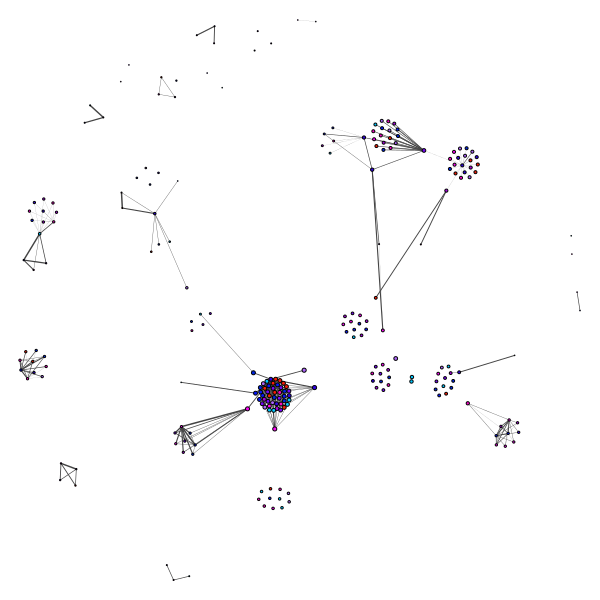

In [23]:
##ORIGINAL FEITO PARA VISUALIZAÇÃO MELHOR NO IGRAPH

links = []
with open('redeFiliacao.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        institution1 = row['institution1']
        institution2 = row['institution2']
        num = int(row['num'])
        links.append((institution1, institution2, num))

nodes = set()  # Usando um conjunto para garantir nós únicos
for link in links:
    nodes.add(link[0])
    nodes.add(link[1])

node_indices = {node: i for i, node in enumerate(nodes)}

edges = []
edge_widths = []
for link in links:
    institution1, institution2, num = link
    if institution1 != institution2:
        edge = (node_indices[institution1], node_indices[institution2])
        if edge not in edges and (edge[1], edge[0]) not in edges:
            edges.append(edge)
            edge_widths.append(math.log(num))

g = Graph()
g.add_vertices(len(nodes))
g.add_edges(edges)

g.vs["name"] = list(nodes)

color_palette = ["#FC05F6", "#A704E0", "#7707F7", "#2F04E0", "#0518FC", "#F81D05", "#F705C8", "#0025E0", "#00C8FF", "#AC64FA"]  # Exemplo de paleta de cores
node_colors = [color_palette[i % len(color_palette)] for i in range(len(nodes))]
g.vs["color"] = node_colors

# Calcula o tamanho logarítmico dos nós
node_sizes = [math.log(g.degree(node) + 1) for node in g.vs]
g.vs["size"] = node_sizes

# Calcula a escala logarítmica das arestas
edge_widths = [math.log(width + 1e-6) for width in edge_widths]


g.es["width"] = edge_widths

layout = g.layout_fruchterman_reingold()
plot(g, layout=layout)

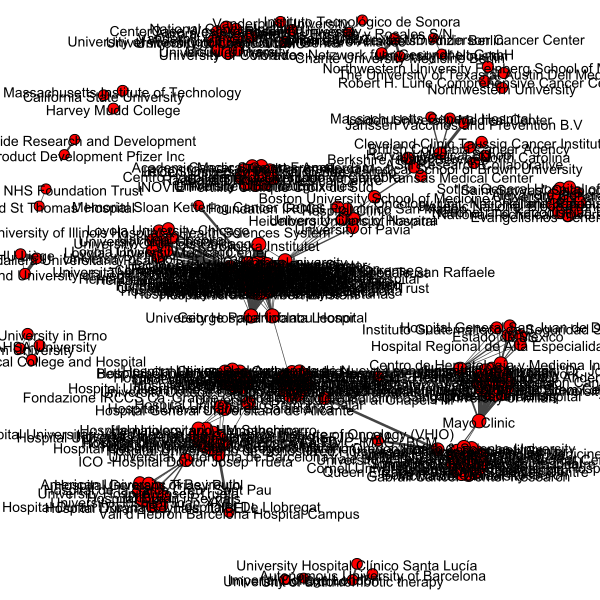

In [83]:
##ALTERADO PARA TESTAR VISUALIZAÇÃO NO SIGMAJS
links = []
with open('redeFiliacao.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        institution1 = row['institution1']
        institution2 = row['institution2']
        num = int(row['num'])
        links.append((institution1, institution2, num))

nodes = set()  # Usando um conjunto para garantir nós únicos
for link in links:
    nodes.add(link[0])
    nodes.add(link[1])

node_indices = {node: i for i, node in enumerate(nodes)}

edges = []
edge_widths = []
for link in links:
    institution1, institution2, num = link
    if institution1 != institution2:
        edge = (node_indices[institution1], node_indices[institution2])
        if edge not in edges and (edge[1], edge[0]) not in edges:
            edges.append(edge)
            edge_widths.append(math.log(num))

gFiliacao = Graph()
gFiliacao.add_vertices(len(nodes))
gFiliacao.add_edges(edges)

gFiliacao.vs["name"] = list(nodes)
gFiliacao.vs["label"] = gFiliacao.vs["name"]  # Adiciona as instituições como rótulos dos nós

# Calcula o tamanho logarítmico dos nós
node_sizes = [math.log(gFiliacao.degree(node))+10 for node in gFiliacao.vs]
gFiliacao.vs["size"] = node_sizes

# Calcula a escala logarítmica das arestas
edge_widths = [width for width in edge_widths]
gFiliacao.es["width"] = edge_widths

layout = gFiliacao.layout_fruchterman_reingold()
plot(gFiliacao, layout=layout)

In [51]:
print("Número de vértices em g:", g.vcount())
print("Número de arestas em g:", g.ecount())

Número de vértices em g: 238
Número de arestas em g: 2279


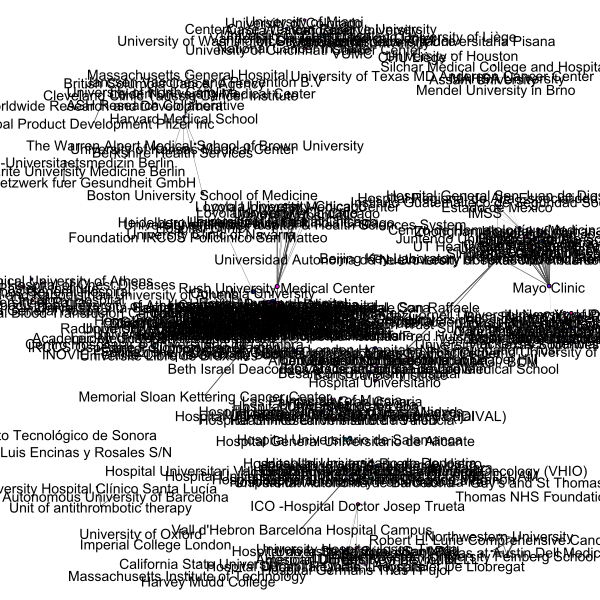

In [24]:
links = []
with open('redeFiliacao.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        institution1 = row['institution1']
        institution2 = row['institution2']
        num = int(row['num'])
        links.append((institution1, institution2, num))

nodes = set()  # Usando um conjunto para garantir nós únicos
for link in links:
    nodes.add(link[0])
    nodes.add(link[1])

node_indices = {node: i for i, node in enumerate(nodes)}

edges = []
edge_widths = []
for link in links:
    institution1, institution2, num = link
    if institution1 != institution2:
        edge = (node_indices[institution1], node_indices[institution2])
        if edge not in edges and (edge[1], edge[0]) not in edges:
            edges.append(edge)
            edge_widths.append(math.log(num))

g = Graph()
g.add_vertices(len(nodes))
g.add_edges(edges)

g.vs["name"] = list(nodes)
g.vs["label"] = g.vs["name"]  # Adiciona as instituições como rótulos dos nós

color_palette = ["#FC05F6", "#A704E0", "#7707F7", "#2F04E0", "#0518FC", "#F81D05", "#F705C8", "#0025E0", "#00C8FF", "#AC64FA"]  # Exemplo de paleta de cores
node_colors = [color_palette[i % len(color_palette)] for i in range(len(nodes))]
g.vs["color"] = node_colors

# Calcula o tamanho logarítmico dos nós
node_sizes = [math.log(g.degree(node) + 1) for node in g.vs]
g.vs["size"] = node_sizes

# Calcula a escala logarítmica das arestas
edge_widths = [math.log(width + 1e-6) for width in edge_widths]


g.es["width"] = edge_widths

layout = g.layout_fruchterman_reingold()
plot(g, layout=layout)

In [113]:
# Obtém o caminho absoluto do diretório atual
current_dir = os.getcwd()

# Constrói o caminho completo para o arquivo JSON
json_path = os.path.join(current_dir, 'RedeFiliacaoColoridoComunidades.json')

# Chama a função ig_to_json passando o caminho completo
ig_to_json(gFiliacao, json_path)

True

In [68]:
#Tirar o filtro por ano e colocar a palavra 'coronavac', deixar fácil 
#procurar nas referencias por titulo
#fazer a medida de centralidade, primeiro a função do between e depois
#fazer uma escala para o tamanho, plotar no grafo e ver ficar bonito

# Betweenness
Conta quantos caminhos mais curtos entre pares de nós passam pelo nó, indica nós que são pontes na comunicação entre diferentes partes da rede, identifica nós que quando removidos podem afetar a conexão entre outros nós.

In [14]:
betweenness = gFiliacao.betweenness()
print(betweenness)

[0.0, 0.0, 183.0, 0.0, 0.0, 1408.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3457.833333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 814.0000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 99.16666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3493.9999999999986, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2723.0, 809.6666666666663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2716.0000000000014, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3407.166666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2839.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 183.0, 0.0, 1903.0, 0.0, 0.0

In [19]:
print(len(betweenness))

238


In [15]:
# Calcule o máximo e o mínimo do betweenness
max_betweenness = max(betweenness)
min_betweenness = min(betweenness)
print(min_betweenness)
print(max_betweenness)

# Aplique a escala de 0 a 1 ao betweenness
scaled_betweenness = [(b - min_betweenness) / (max_betweenness - min_betweenness) for b in betweenness]

0.0
4888.499999999998


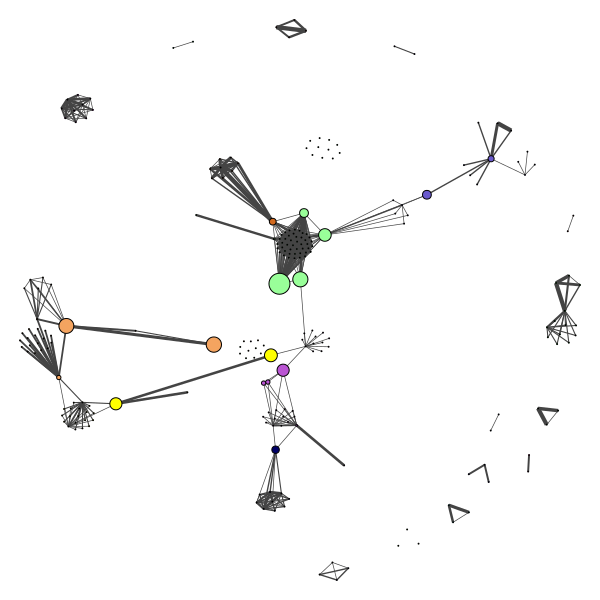

In [116]:
# Define o tamanho dos nós com base no betweenness escalado
# Calcula os tamanhos dos nós com escala logarítmica
gFiliacao.vs["size"] = [1 + 20 * b for b in scaled_betweenness]
gFiliacao.vs["label"] = ""#gFiliacao.vs["name"]  # Adiciona as instituições como rótulos dos nós
# Plota o grafo
layout = gFiliacao.layout_fruchterman_reingold()
plot(gFiliacao, layout=layout)

# Degree
Calcula o grau do nó, que é o número de arestas que estão conectadas ao nó, quantidade de conexões. 

In [20]:
node_degrees = gFiliacao.degree()
print(node_degrees)
print(len(node_degrees))

[9, 14, 17, 20, 11, 56, 3, 3, 20, 1, 16, 14, 62, 9, 9, 14, 16, 11, 6, 16, 1, 1, 15, 1, 11, 48, 48, 2, 20, 16, 6, 9, 9, 20, 48, 11, 29, 9, 19, 2, 6, 8, 4, 24, 48, 2, 11, 14, 3, 9, 17, 1, 9, 2, 15, 20, 48, 16, 9, 14, 48, 9, 11, 9, 1, 48, 8, 43, 39, 48, 48, 48, 6, 19, 2, 4, 22, 2, 20, 6, 2, 11, 9, 1, 19, 11, 3, 8, 48, 16, 14, 26, 3, 19, 19, 6, 48, 1, 15, 2, 48, 1, 3, 48, 19, 15, 48, 11, 3, 16, 6, 14, 3, 9, 9, 3, 19, 19, 9, 19, 48, 19, 8, 48, 20, 19, 1, 20, 2, 4, 19, 3, 1, 16, 19, 48, 9, 9, 9, 9, 54, 48, 48, 48, 6, 48, 15, 16, 9, 4, 1, 4, 48, 9, 48, 19, 14, 2, 48, 20, 48, 1, 9, 48, 2, 20, 14, 16, 48, 20, 15, 3, 49, 4, 10, 4, 14, 16, 2, 11, 19, 20, 48, 19, 48, 8, 9, 20, 48, 48, 19, 20, 48, 8, 15, 63, 20, 15, 16, 14, 2, 20, 9, 48, 15, 8, 2, 16, 48, 6, 20, 14, 59, 11, 9, 25, 48, 48, 48, 11, 20, 6, 8, 20, 9, 48, 48, 2, 9, 29, 9, 15, 48, 48, 12, 48, 2, 15]
238


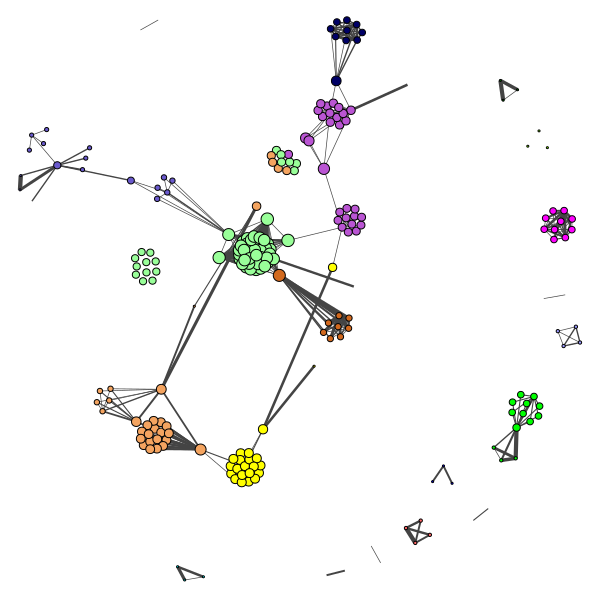

In [120]:
gFiliacao.vs["size"] = [math.log(degree) * 3 for degree in node_degrees]
layout = gFiliacao.layout_fruchterman_reingold()
plot(gFiliacao, layout=layout)

# Closeness
Calcula a medida de centralidade para cada nó, medindo o quão próximo ele está de todos os outros nós do grafo
Nós com valores maiores são mais centrais(próximos de todos os outros nós em média). 
Quando é 1, significa que ele é alcançado por todos os nós.

divide a distância de cada nó e

In [36]:
closeness_centralities = gFiliacao.closeness()
print(closeness_centralities)

[1.0, 0.37782340862423, 0.31724137931034485, 0.2713864306784661, 0.2948717948717949, 0.4052863436123348, 0.5714285714285714, 1.0, 0.2713864306784661, 1.0, 0.31669535283993117, 0.37782340862423, 0.4577114427860697, 0.8, 1.0, 0.37782340862423, 0.31669535283993117, 0.2948717948717949, 0.2598870056497175, 0.31669535283993117, 1.0, 1.0, 0.3817427385892116, 1.0, 0.2948717948717949, 0.39826839826839827, 0.39826839826839827, 1.0, 0.2713864306784661, 0.31669535283993117, 0.3006535947712418, 0.8, 0.2463186077643909, 0.2713864306784661, 0.39826839826839827, 0.2948717948717949, 0.4017467248908297, 0.8, 0.27340267459138184, 0.32, 0.2598870056497175, 0.2920634920634921, 0.19429778247096094, 0.2754491017964072, 0.39826839826839827, 1.0, 0.2948717948717949, 0.37782340862423, 0.5714285714285714, 0.8, 0.42105263157894735, 0.2857142857142857, 1.0, 0.19388830347734456, 0.3817427385892116, 0.2713864306784661, 0.39826839826839827, 0.31669535283993117, 0.2463186077643909, 0.37782340862423, 0.3982683982683982

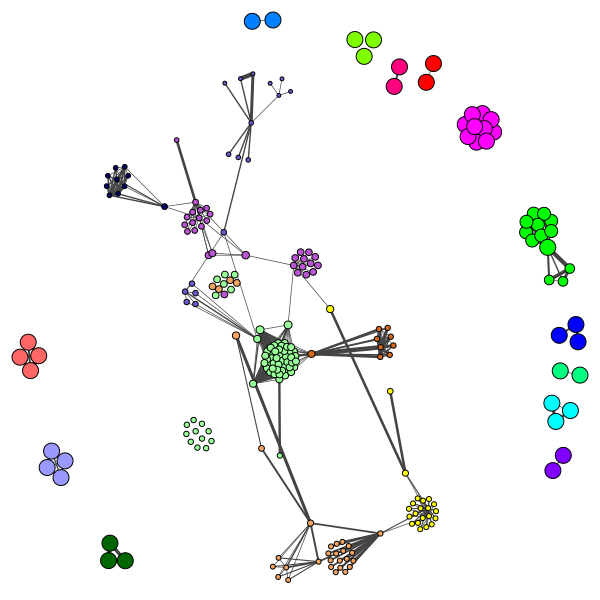

In [117]:
gFiliacao.vs["size"] = [1 + 15 * closeness for closeness in closeness_centralities]

# Plote o grafo
layout = gFiliacao.layout_auto()

plot(gFiliacao, layout=layout)

In [ ]:
#colorir com comunidades: 
#comunidades = g.fastgreedy()
#colorido - comunidades

#alterar a lista para aparecer todos os nomes/numeros q ele tem conexao

# Colorir com comunidades

In [48]:
import random

In [86]:
color_palette = ["aliceblue", "lavender", "powderblue", "lightblue", "lightskyblue", "skyblue", "deepskyblue", "lightsteelblue", "dodgerblue", "steelblue", "cadetblue", "mediumslateblue", "slateblue", "darkslateblue", "royalblue", "blue", "mediumblue","darkblue","navy","midnightblue","blueviolet","indigo"]  # Exemplo de paleta de cores

In [110]:
color_palette = ["#FF0000", "#FF8000", "#FFFF00", "#80FF00", "#00FF00", "#00FF80", "#00FFFF", "#0080FF", "#0000FF", "#7F00FF", "#FF00FF", "#FF007F", "#000066", "#660066", "#006600","#FF6666","#FF99CC","#9999FF","#99FF99","#6A5ACD", "#BA55D3", "#D2691E","#F4A460"]  # Exemplo de paleta de cores

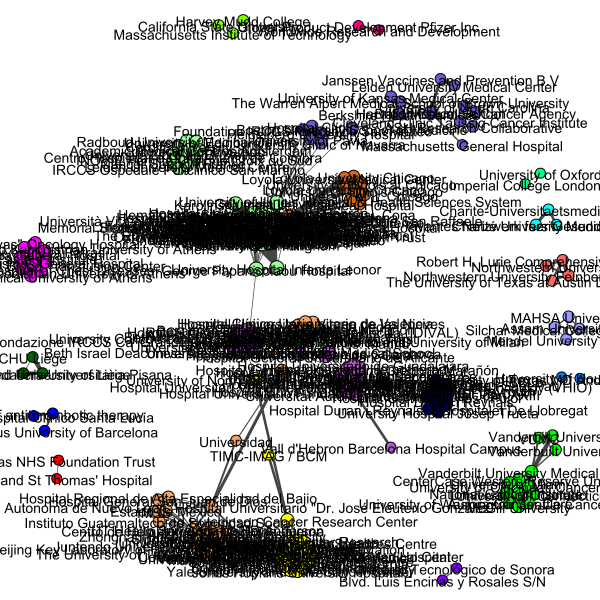

In [112]:
available_colors = color_palette.copy()  # Cria uma cópia da lista de cores

# Executar o algoritmo fastgreedy para identificar os clusters
communities = gFiliacao.community_fastgreedy(weights=gFiliacao.es['width'])
clusters = communities.as_clustering()

# Criar um dicionário para mapear o número do cluster para uma cor aleatória e faz a verificação se todas foram usadas para poder repetir
cluster_to_color = {}
for cluster_num in range(len(clusters)):
    if(len(available_colors)>0):
        color = random.choice(available_colors)
        available_colors.remove(color)
    if(len(available_colors)==0):
        available_colors=color_palette
    cluster_to_color[cluster_num] = color

# Definir as cores dos nós com base nos clusters
gFiliacao.vs["color"] = [cluster_to_color[cluster_num] for cluster_num in clusters.membership]

# Plotar o grafo
layout = gFiliacao.layout_fruchterman_reingold()
plot(gFiliacao, layout=layout)

In [103]:
print(clusters)

Clustering with 238 elements and 20 clusters
[ 0] "Saint Savvas" Oncology Hospital, Alexandra General Hospital, University
     of Patras, Hellenic National Blood Transfusion Center, Oncology Unit,
     National and Kapodistrian University of Athens, Sotiria General Hospital
     of Chest Diseases, National Technical University of Athens, National and
     Kapodistrian University of Athens, Evangelismos General Hospital,
     Hellenic Pasteur Institute
[ 1] Fondazione IRCCS Ca' Grande Ospedale Maggiore Policlinico and University
     of Milan, Universitat Autònoma de Barcelona, Hospital Universitario de La
     Princesa, Université catholique de Louvain, Université Catholique de
     Louvain, Hospital Universitari i Politècnic La Fe, Hospital General
     Universitario Gregorio Marañón, Hospital Universitario Fundación Jiménez
     Díaz-IISFJD-UAM, Hospital General Universitario de Alicante, University
     of Leeds, Hospital Universitari Vall d'Hebron. Vall d'Hebron Institute of
     

In [111]:
print(len(color_palette))

23
